# T-SNE & UMAP
T-SNE (https://lvdmaaten.github.io/tsne/) and UMAP (https://github.com/lmcinnes/umap) are two technicalities, often used by data scientists, that allow to project multivariate data into lower dimensions. They are often used to find clusters in data. I used the fast t-SNE and UMAP implementations offered by Rapids (they require GPU access). 

As stated by the article "How to t-SNE Effectively" (https://distill.pub/2016/misread-tsne/), it is easy to see clusters where there are not, and in our data there are no clear macro clusters, probably. What can be inferedded by t-SNE and UMAP projects, though, is that there are many local clusters, just like in mixture of (this is what can be read from t-SNE). Also there are probably a few outliers, given the noise injected into the artificial data (and this can be read from UMAP, where a few central clusters are surronded by very small scattered ones).

I wonder if, given such evidence, gaussian mixtures may prove a good feature engineering approach.

In [1]:
%%time
import sys
!cp -f ../input/rapids/rapids.21.06 /opt/conda/envs/rapids.tar.gz
!cd -f /opt/conda/envs/ && tar -xzvf rapids.tar.gz
sys.path = ["/opt/conda/envs/rapids/lib"] + ["/opt/conda/envs/rapids/lib/python3.7"] + ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
!cp -f /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

/bin/bash: line 0: cd: -f: invalid option
cd: usage: cd [-L|[-P [-e]] [-@]] [dir]
cp: cannot stat '/opt/conda/envs/rapids/lib/libxgboost.so': No such file or directory
CPU times: user 404 ms, sys: 137 ms, total: 540 ms
Wall time: 29.7 s


In [2]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import os
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Regressors
import lightgbm as lgb

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# 
import cudf, cuml
import cupy as cp
from cuml.manifold import TSNE, UMAP
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim, xlim
%matplotlib inline

In [3]:
# Loading data 
X = pd.read_csv("../input/30-days-of-ml/train.csv")
X_test = pd.read_csv("../input/30-days-of-ml/test.csv")

In [4]:
# Preparing data as a tabular matrix
y = X.target
X = X.set_index('id').drop('target', axis='columns')
X_test = X_test.set_index('id')

In [5]:
# Stratifying the target
y_stratified = pd.cut(y, bins=10, labels=False)

In [6]:
# Dealing with categorical data
categoricals = [item for item in X.columns if 'cat' in item]
numeric = [item for item in X.columns if 'cat' not in item]
ordinal_encoder = OrdinalEncoder()
X[categoricals] = ordinal_encoder.fit_transform(X[categoricals]).astype(int)
X_test[categoricals] = ordinal_encoder.transform(X_test[categoricals]).astype(int)

In [7]:
ohe = OneHotEncoder(sparse=False)
H = np.hstack((ohe.fit_transform(X[categoricals]), X[numeric].values))

In [8]:
tsne = TSNE(n_components=2, perplexity=10, n_neighbors=100)
projection_2D = tsne.fit_transform(H)

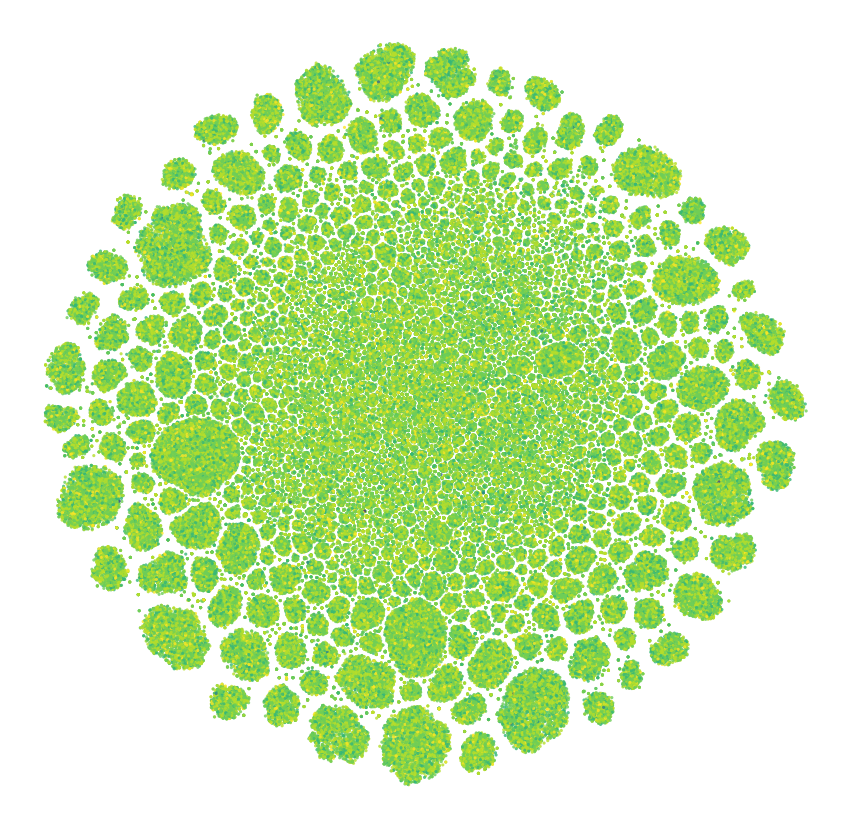

In [9]:
plt.figure(figsize=(15, 15))
plt.scatter(projection_2D[:,0], projection_2D[:,1],
            c=y_stratified.values, 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
plt.axis('off')
plt.show();

In [10]:
umap = UMAP(n_components=2, n_neighbors=50)
projection_2D = umap.fit_transform(H)

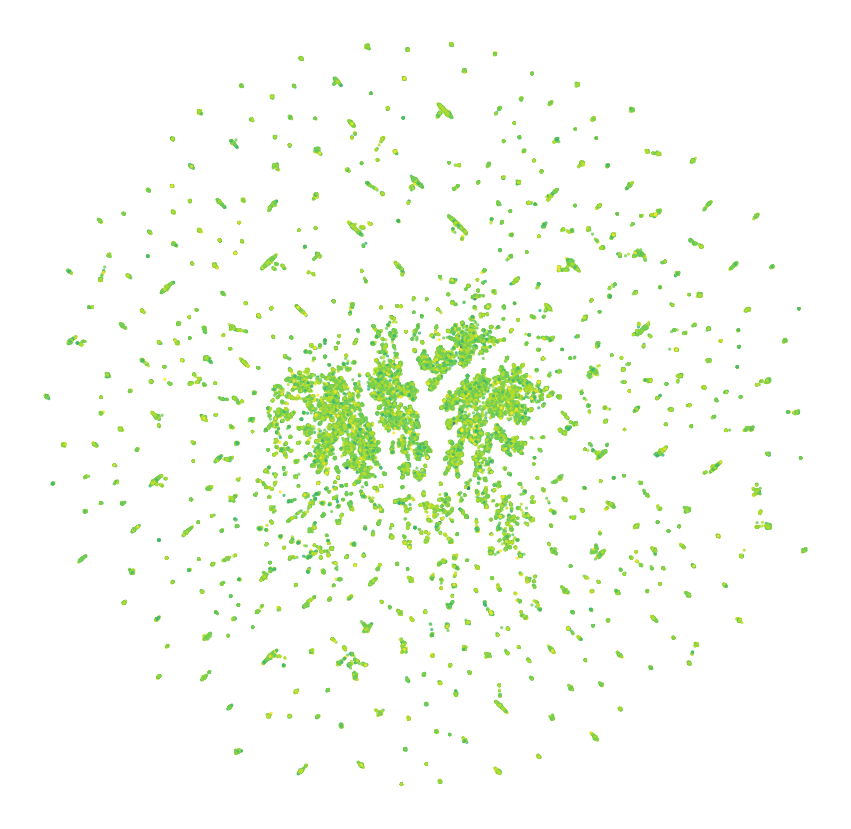

In [11]:
plt.figure(figsize=(15, 15))
plt.scatter(projection_2D[:,0], projection_2D[:,1],
            c=y_stratified.values, 
            edgecolor='none', 
            alpha=0.80, 
            s=10)
plt.axis('off')
plt.show();

In [12]:
Ht = np.hstack((ohe.transform(X_test[categoricals]), X_test[numeric].values))
_ = pd.DataFrame(umap.transform(H), columns = ['umap_0', 'umap_1'], index=X.index).reset_index().to_csv('umap_train.csv', index=False)
_ = pd.DataFrame(umap.transform(Ht), columns = ['umap_0', 'umap_1'], index=X_test.index).reset_index().to_csv('umap_test.csv', index=False)